In [1]:
import numpy as np
from numpy import save
from numpy import asarray
from numpy import load

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import tensorflow as tf
import random
import progressbar
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, MaxPool2D, LeakyReLU


In [2]:
joint_name = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM', 'SpineL', 
            'Offset1', 'Offset2', 'HipL', 'HipR', 'ElbowL', 'ArmL', 
            'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 
            'KneeL', 'ShinL', 'ShinR']

joints_idx = [[1, 2], [2, 3], [1, 3], [2, 4], [1, 4], [3, 4], [4, 5], 
            [5, 6], [4, 7], [7, 8], [5, 8], [5, 7], [6, 8], [6, 9], 
            [6, 10], [11, 12], [4, 13], [4, 14], [11, 13], [12, 13], 
            [14, 15], [14, 16], [15, 16], [9, 18], [10, 17], [18, 19], 
            [17, 20]]

In [3]:
# normalizes a matrix
def normalize(matrix):
    max_numb = max(matrix[~np.isnan(matrix)])
    norm = matrix/max_numb
    return np.array(norm)
    # return matrix

In [4]:
from scipy.spatial.distance import cdist
# Get the distance to every single point 
def getAllDistances(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    dist = cdist(mat, mat, 'euclidean')
    return normalize(dist)

In [5]:
# Get the absolute height difference to every single point 
def getAllHeights(matFile, numb):
    mat = matFile[numb]
    z = mat[2]
    reshaped = int(matFile.shape[2])
    height = []

    for i in range(reshaped):
        for j in range(reshaped):
            if np.nan in [z[i], z[j]]:
                height.append(np.nan)
            else:
                height.append(np.abs(z[i]-z[j]))

    # normalizes height data
    height = normalize(np.array(height).reshape(reshaped, reshaped))
    return height


In [6]:
# Get the angle to every single point 
def getAllAngles(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    angle = cdist(mat, mat, 'cosine')
    return normalize(angle)

In [7]:
def getData(data, numb): 
    cnn_inputs = []
    bar = progressbar.ProgressBar()

    for i in bar(range(numb)):
        dist = getAllDistances(data, i) 
        height = getAllHeights(data, i)
        angle = getAllAngles(data, i)
        for j in range(0, data.shape[2]):
            temp = np.array([dist[j], height[j], angle[j]])
            first = temp[:,0:3]
            second = temp[:,3:20]
            first = first [ :, first[0].argsort()]
            second = second [ :, second[0].argsort()]
            output = np.concatenate((first, second), axis =1)
            cnn_inputs.append(output)

    # DIMENTION CHANGE
    cnn_inputs = np.array(cnn_inputs)[:,:,:13]
    # cnn_inputs = np.array(cnn_inputs)[:,:,:20]
    cnn_inputs = np.array(cnn_inputs).reshape((cnn_inputs.shape[0], 39))
    # cnn_inputs = np.array(cnn_inputs).reshape((numb*data.shape[2], 60))
    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0
    return cnn_inputs


In [8]:
train_file = loadmat('mat_files/bigSet2.mat')
test_file = loadmat('mat_files/bigSet3.mat')

In [9]:
train_data = train_file['bigSet2']
test_data = test_file['bigSet3']
train_labels = train_file['labels2']
test_labels = test_file['labels3']
# set numb of data used
numb_train = len(train_data)
numb_test = 1000

# Take some frames from the list to use as trian and test data
# index_train = np.linspace(0, len(train_labels), num = numb_train, endpoint=False).astype(int)
index_test = np.linspace(0, len(test_labels), num = numb_test, endpoint=False).astype(int)
# pre_train_data = train_data[index_train]
# pre_train_labels = train_labels[index_train]
pre_train_data = train_data
pre_train_labels = train_labels
pre_test_data = test_data[index_test]
pre_test_labels = test_labels[index_test]

print("Shape of pre_train_data:", pre_train_data.shape)
print("Shape of pre_test_data:", pre_test_data.shape)
print("Shape of pre_train_labels:", pre_train_labels.shape)
print("Shape of pre_test_labels:", pre_test_labels.shape)


Shape of pre_train_data: (221151, 3, 20)
Shape of pre_test_data: (1000, 3, 20)
Shape of pre_train_labels: (221151, 20)
Shape of pre_test_labels: (1000, 20)


In [10]:
# Get measurement data for every 3D point
train_data = getData(pre_train_data, numb_train)
test_data = getData(pre_test_data, numb_test)

# Flatten the trian labels to fit dimentions of data
train_labels = pre_train_labels.flatten()[0:(numb_train*20)]-1
test_labels = pre_test_labels.flatten()[0:(numb_test*20)]-1

print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_labels:", test_labels.shape)

100% (221151 of 221151) |################| Elapsed Time: 0:06:49 Time:  0:06:49
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


Shape of train_data: (4423020, 39)
Shape of test_data: (20000, 39)
Shape of train_labels: (4423020,)
Shape of test_labels: (20000,)


In [11]:
# Get index where the data is all 0
nans_train = np.sort(np.where(~train_data.any(axis=1))[0])[::-1]
nans_test = np.sort(np.where(~test_data.any(axis=1))[0])[::-1]

# Turn data into lists
train_data_new = list(train_data)
test_data_new = list(test_data)
train_labels_new = list(train_labels)
test_labels_new = list(test_labels)

bar = progressbar.ProgressBar()
# Remove the nan values 
for i in bar(nans_train):
    train_data_new.pop(i)
    train_labels_new.pop(i)
bar = progressbar.ProgressBar()
for i in bar(nans_test):
    test_data_new.pop(i)
    test_labels_new.pop(i)

# Turn data back into array
train_data_new = np.array(train_data_new)
train_labels_new = np.array(train_labels_new)
test_data_new = np.array(test_data_new)
test_labels_new = np.array(test_labels_new)

print("Shape of train_data_new:", train_data_new.shape)
print("Shape of test_data_new:", test_data_new.shape)
print("Shape of train_labels_new:", train_labels_new.shape)
print("Shape of test_labels_new:", test_labels_new.shape)

100% (397728 of 397728) |################| Elapsed Time: 0:27:24 Time:  0:27:24
100% (1819 of 1819) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


Shape of train_data_new: (4025292, 39)
Shape of test_data_new: (18181, 39)
Shape of train_labels_new: (4025292,)
Shape of test_labels_new: (18181,)


In [16]:
# Creates the ML training platform to predict rat joints
def ml_traning(train_data, train_labels, test_data, test_labels):
    # DIMENTION CHANGE
    train_data = train_data.reshape(train_data.shape[0], 39)
    test_data = test_data.reshape(test_data.shape[0], 39)
    # train_data = train_data.reshape(train_data.shape[0], 60)
    # test_data = test_data.reshape(test_data.shape[0], 60)
    train_data = train_data.astype('float32')
    test_data = test_data.astype('float32')

    model = createModel()
    checkpoint_path = "training_2/cp.ckpt"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

    model.fit(x=train_data,y=train_labels, verbose='auto', batch_size=500, epochs=5, validation_data=(test_data, test_labels), callbacks=[cp_callback])
    
    loss, acc = model.evaluate(test_data, test_labels, verbose=2)
    print("Loss:", loss)
    print("Accuracy:", acc*100)
    return model

# Creates the model for the CNN
def createModel():
    model = Sequential()
    model.add(Dense(120, activation= LeakyReLU()))
    model.add(Dense(320, activation= LeakyReLU()))
    # model.add(Dropout(rate=0.25))
    model.add(Dense(80, activation= LeakyReLU()))
    # model.add(Dense(13, activation = "softmax"))
    model.add(Dense(len(joint_name), activation = "softmax"))
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
# save_train_data = asarray(train_data_new)
# save_train_labels = asarray(train_labels_new)
# save_test_data = asarray(test_data_new)
# save_test_labels = asarray(test_labels_new)

In [14]:
# folder = 'datasets/'
# save(folder + 'train_data.npy', save_train_data)
# save(folder + 'train_labels.npy', save_train_labels)
# save(folder + 'test_data.npy', save_test_data)
# save(folder + 'test_labels.npy', save_test_labels)

In [17]:
skeleton_model = ml_traning(train_data_new, train_labels_new, test_data_new, test_labels_new)

Epoch 1/5
8051/8051 [==============================] - 72s 9ms/step - loss: 0.7657 - accuracy: 0.7583 - val_loss: 0.9164 - val_accuracy: 0.7408

Epoch 00001: saving model to training_2/cp.ckpt
Epoch 2/5
8051/8051 [==============================] - 69s 9ms/step - loss: 0.4668 - accuracy: 0.8547 - val_loss: 0.8417 - val_accuracy: 0.7753

Epoch 00002: saving model to training_2/cp.ckpt
Epoch 3/5
8051/8051 [==============================] - 65s 8ms/step - loss: 0.3808 - accuracy: 0.8810 - val_loss: 0.8251 - val_accuracy: 0.7839

Epoch 00003: saving model to training_2/cp.ckpt
Epoch 4/5
8051/8051 [==============================] - 57s 7ms/step - loss: 0.3353 - accuracy: 0.8954 - val_loss: 0.8223 - val_accuracy: 0.7901

Epoch 00004: saving model to training_2/cp.ckpt
Epoch 5/5
8051/8051 [==============================] - 65s 8ms/step - loss: 0.3065 - accuracy: 0.9043 - val_loss: 0.7999 - val_accuracy: 0.7990

Epoch 00005: saving model to training_2/cp.ckpt
569/569 - 1s - loss: 0.7999 - accur

In [18]:
# skeleton_model = ml_traning(train_data_new, train_labels_new, test_data_new, test_labels_new)
checkpoint_path = "training_2/cp.ckpt"
temp_model = createModel()
temp_model.load_weights(checkpoint_path).expect_partial()

# Re-evaluate the model
loss, acc = temp_model.evaluate(test_data, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

625/625 - 1s - loss: 1.5841 - accuracy: 0.7263
Restored model, accuracy: 72.63%


In [19]:
# Tests individual points and tells you if the CNN worked
def handTest(image_index, test_data, label, model, maxNumb):
    max_index = len(joint_name)*maxNumb-1
    if image_index <= max_index:
        predict(test_data, image_index, label, model)
    else:
        print("ERROR: Your predict_index must be below", max_index)

# Showing individual predictions
def predict(data, image_index, label, model):
    img = [data[image_index]]
    # DIMENTION CHANGE
    img = np.array(img).reshape(3,13)
    # img = np.array(img).reshape(3,20)
    plt.imshow(img)
    plt.show()

    pred = model.predict(img.reshape(1, 39))
    # pred = model.predict(img.reshape(1, 60))
    predict = pred.argmax()
    actual = label[image_index]

    print("Actual:", actual)
    print("Predicted:", predict)
    
    if predict == actual:
        print("YAY ✿(ᵔ‿ᵔ)")
    else:
        print("Wrong (◕︵◕)")

    

In [20]:
# for i in range(420,440):
#     handTest(i, test_data, test_labels, skeleton_model, numb_test)

Train input


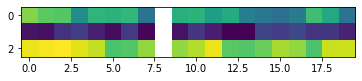

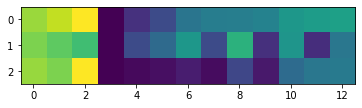

Test input


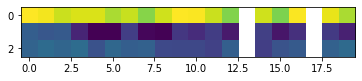

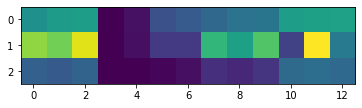

In [21]:
# index = 1234
# frame = int(index/20)

# print("Train input")
# plt.imshow(pre_train_data[frame].reshape(3,20))
# plt.show()
# # DIMENTION CHANGE
# plt.imshow(train_data[index].reshape(3,13))
# plt.show()

# print("Test input")
# plt.imshow(pre_test_data[frame].reshape(3,20))
# plt.show()
# plt.imshow(test_data[index].reshape(3,13))
# plt.show()

In [9]:
temporal = loadmat('mat_files/test_temp.mat')

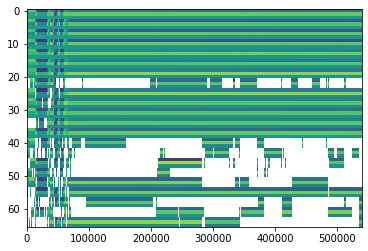

In [10]:
time_pts = temporal['new_combed']
num_fms = 3000
num_pts = int(time_pts.shape[0]/3) #22
test_pts = time_pts[:,:num_fms]

plt.imshow(time_pts, interpolation='nearest', aspect="auto")
plt.show()
# plt.imshow(test_pts, interpolation='nearest', aspect="auto")
# plt.show()

In [11]:
input_pts = test_pts.reshape(num_pts, 3, num_fms).T

In [12]:
processed_time = getData(input_pts, len(input_pts))
process_pts = processed_time.reshape(3000, 22, 39)
temp = processed_time.reshape(3000, 22, 39)
processed = np.transpose(temp,(1, 0, 2))

NameError: name 'getData' is not defined

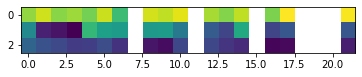

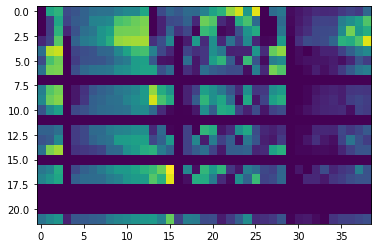

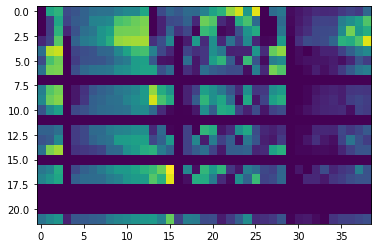

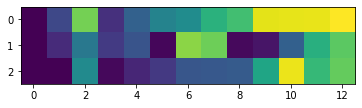

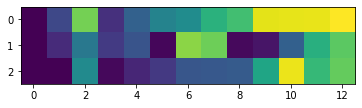

In [26]:
# # Check if process_pts is valid

# frame_index = 2999
# pt = 2
# plt.imshow(input_pts[frame_index].reshape(3,num_pts))
# plt.show()

# plt.imshow(process_pts[frame_index], interpolation='nearest', aspect="auto")
# plt.show()



# # plt.imshow([presplit_process[frame_index]], interpolation='nearest', aspect="auto")
# plt.imshow(processed[:,frame_index], interpolation='nearest', aspect="auto")
# plt.show()

# plt.imshow(process_pts[frame_index][pt].reshape(3,13))
# plt.show()
# plt.imshow(processed[pt][frame_index].reshape(3,13))
# plt.show()

In [15]:
chunks = []
temp = np.ones((22,3000))
bar = progressbar.ProgressBar()
# run through all the registered points (0,22)
for i in bar(range(num_pts)):
    # get every third row
    row = i*3
    row_list = []
    temp_list = []

    # run through length of each row (0,3000)
    for j in range(num_fms): 
        # not a nan, add index to list
        if not np.isnan(test_pts[row][j]):
            temp_list.append(j)
            temp[i][j] = temp[i][j]*2
        # if element is a nan and the current list is not empty
        elif len(temp_list) > 0:
            # add list to output and clear the list
            row_list.append([temp_list[0], temp_list[-1]])
            temp_list = []
    # edge case, add to output if the list still contains values
    if len(temp_list) > 0:
        row_list.append([temp_list[0], temp_list[-1]])
    chunks.append(row_list)

100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [13]:
# plt.imshow(temp, interpolation='nearest', aspect="auto")
# plt.show
# plt.imshow(test_pts, interpolation='nearest', aspect="auto")
# plt.show

In [16]:
# Check the chunk list
chunks = np.array(chunks, dtype=list)
for i in range(len(chunks)):
    print("Point: "+str(i) +", Chunks: " + str(len(chunks[i])))

Point: 0, Chunks: 1
Point: 1, Chunks: 1
Point: 2, Chunks: 1
Point: 3, Chunks: 1
Point: 4, Chunks: 1
Point: 5, Chunks: 1
Point: 6, Chunks: 1
Point: 7, Chunks: 11
Point: 8, Chunks: 1
Point: 9, Chunks: 1
Point: 10, Chunks: 1
Point: 11, Chunks: 12
Point: 12, Chunks: 1
Point: 13, Chunks: 7
Point: 14, Chunks: 1
Point: 15, Chunks: 27
Point: 16, Chunks: 9
Point: 17, Chunks: 34
Point: 18, Chunks: 26
Point: 19, Chunks: 18
Point: 20, Chunks: 12
Point: 21, Chunks: 24


In [30]:
from scipy import stats
temporal_data = []
predict_numbs = []
confidence_levels = []

# loop through all the points (0,22)
for i in range(len(chunks)):
# for i in range(3):
    seg_range = []
    mode_predict = []
    conf_predict = []
    conf_level = []
    pred_numbs = []


    # list of chunks in a row
    data = chunks[i]
    print("\nPoint: "+ str(i) + ", Segments: " + str(len(data)))
    # loop through all the chunks per row (0,1)
    for j in range(len(data)):
        conf = []
        pred = []
        seg = data[j] #segment range ie. [0,2999]
        lower = seg[0]
        upper = seg[1]+1
        seg_len = upper - lower
        
        # loop through range of each chunk (0,3000)
        bar = progressbar.ProgressBar()
        for k in range(lower, upper): 
        # for k in range(100):
            # if k < 5:
            #     plt.imshow(processed[i][k].reshape(3,13))
            #     plt.show()
            model_pred = skeleton_model.predict(processed[i][k].reshape(1,39))

            # get the confidence of predicition
            if len(conf) == 0: 
                conf = model_pred[0]
            else:
                conf += model_pred[0]

            # get prediction
            pred.append(model_pred.argmax())
            
        # turn into arrays
        conf = np.array(conf)
        pred = np.array(pred)

        # get mode predictions
        mode_data = stats.mode(pred, axis = 0)
        mode_pred = mode_data[0].flatten()[0]
        mode_count = mode_data[1].flatten()[0]
        mode_conf = mode_count/seg_len

        # get confidence predictions
        conf_pred = conf.argmax()
        conf_count = np.sum(pred == conf_pred)
        conf_conf = conf.max()/seg_len

        # adding to output arrays
        # seg_range.append(seg)
        conf_level.append(conf)
        pred_numbs.append(pred)
        mode_predict.append([mode_pred, mode_conf, seg, (seg_len-mode_count), mode_count, seg_len])
        conf_predict.append([conf_pred, conf_conf, seg, (seg_len-conf_count), conf_count, seg_len])

        # Display current state
        print("Segment: "+str(j) + ")", seg, "Predicted point: (M:" + str(mode_pred) + ", C:" + str(conf_pred) + "), [" + str(mode_count) + ", " + str(conf_count) + "] /", seg_len, end = " ")
        if (mode_pred == conf_pred):
            print("Yay")
        else:
            print("Conflict")
    
    # adding to output arrays
    confidence_levels.append(conf_level)
    predict_numbs.append(pred_numbs)
    temporal_data.append([mode_predict, conf_predict])


Point: 0, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:2, C:2), [3000, 3000] / 3000 Yay

Point: 1, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:1, C:1), [2218, 2218] / 3000 Yay

Point: 2, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:0, C:0), [2554, 2554] / 3000 Yay

Point: 3, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:8, C:8), [1465, 1465] / 3000 Yay

Point: 4, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:8, C:8), [2117, 2117] / 3000 Yay

Point: 5, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:3, C:3), [2403, 2403] / 3000 Yay

Point: 6, Segments: 1
Segment: 0) [0, 2999] Predicted point: (M:16, C:16), [1634, 1634] / 3000 Yay

Point: 7, Segments: 11
Segment: 0) [0, 190] Predicted point: (M:10, C:10), [188, 188] / 191 Yay
Segment: 1) [192, 214] Predicted point: (M:10, C:10), [23, 23] / 23 Yay
Segment: 2) [216, 344] Predicted point: (M:10, C:10), [129, 129] / 129 Yay
Segment: 3) [346, 1432] Predicted point: (M:10, C:10), [1087, 1087] 

In [17]:
# temporal_data
# save_temporal_data = asarray(temporal_data, dtype=object)
# save('datasets/' + 'temporal_data.npy', save_temporal_data)
confidence_levels
predict_numbs
temporal_data = load('datasets/temporal_data.npy', allow_pickle=True)

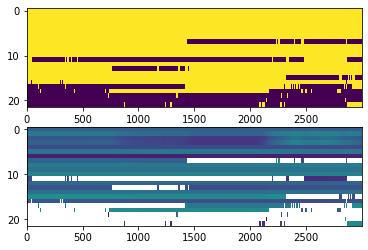

In [18]:
temp_new = np.ones((22,3000))
for i in range(len(temporal_data)):
    for j in range(len(temporal_data[i])):
        for k in range(len(temporal_data[i][j])):
            start = temporal_data[i][j][k][2][0]
            end = temporal_data[i][j][k][2][1] + 1
            for k in range(start, end):
                temp_new[i][k] +=1
fig, (ax1, ax2) = plt.subplots(2)
ax1.imshow(temp_new, interpolation='nearest', aspect="auto")
ax2.imshow(test_pts[::3], interpolation='nearest', aspect="auto")

In [19]:
temp_copy = temporal_data.copy()
temp_data = np.array(temp_copy, dtype=object)
conf_copy = confidence_levels.copy()
conf_data = np.array(conf_copy, dtype=object)


chunk_data = []
chunk_conf = []
pred_data = temp_data[:,1] # 1 for confidence
# pred_data = temp_data[:,0] # 0 for mode
print(pred_data.shape)

for i in range(20):
    chunk_data.append([])
    chunk_conf.append([])

# putting the preditions into buckets
for i in range(20):
    index = pred_data[i]
    conf = conf_data[i]
    for j in range(len(index)):
        chunk_data[index[j][0]].append([i]+index[j])
        chunk_conf[index[j][0]].append([i]+conf[j])

for i in range(len(chunk_data)):
    print(i, len(chunk_data[i]), len(chunk_conf[i]))

NameError: name 'confidence_levels' is not defined

In [59]:
def squish(chunk_data):
    processed_pts = []
    unprocessed_pts = []

    # squish all the data points
    for i in range(20): 
        numb_index = []
        unprocessed = []
        bounds = None
        current = [chunk_data[i]+chunk_conf[i]]
        sorted_current = sorted(current,key=lambda x: x[4])

        for j in reversed(range(len(sorted_current))):
            input_index = sorted_current[j]
            current_bounds = np.arange(input_index[3][0], input_index[3][1]+1).tolist()

            if len(numb_index) == 0:
                numb_index.append(input_index)
                bounds = current_bounds
            else:
                same = list(set(current_bounds) & set(bounds)) # gets overlapping elements 
                # no overlapp between the two lists
                if len(same) == 0:
                    numb_index.append(input_index)
                    bounds += current_bounds
                else: #if there is overlap between the two lists
                    if current_bounds[0] in bounds or current_bounds[-1] in bounds:
                        # print(str(i) + ") Can't add index in range [" + str(current_bounds[0]) + ", " + str(current_bounds[-1]) + "] to [" + str(bounds[0])+ ", " + str(bounds[-1]) + "]")
                        unprocessed.append(input_index)
                        pass
                    elif current_bounds[0] in bounds:
                        print("Lower bound inside current bounds")
                        pass
                    elif current_bounds[-1] in bounds:
                        print("Upper bound inside current bounds")
                        pass
            bounds = sorted(bounds)
        processed_pts.append(numb_index)
        unprocessed_pts.append(unprocessed)
    processed_pts = np.array(processed_pts, dtype = object)
    unprocessed_pts = np.array(unprocessed_pts, dtype = object)
    return processed_pts, unprocessed_pts
 

In [56]:
processed_pts, unprocessed_pts = squish(chunk_data)

In [53]:
print(unprocessed_pts[3][0])

[5, 3, 0.6969020182291666, [0, 2999], 597, 2403, 3000]


In [57]:
for i in range(len(unprocessed_pts)):
    for j in range(len(unprocessed_pts[i])):
        print(unprocessed_pts[i][j])
        plt.imshow(confidence_levels[i][j])

[17, 1, 0.5702477693557739, [341, 344], 0, 4, 4]
[5, 3, 0.6969020182291666, [0, 2999], 597, 2403, 3000]
[17, 3, 0.5028583850793983, [1418, 2276], 193, 666, 859]
[17, 3, 0.4447914123535156, [2393, 2397], 1, 4, 5]
[17, 3, 0.8223458528518677, [102, 103], 0, 2, 2]
[4, 8, 0.4077020263671875, [0, 2999], 883, 2117, 3000]
[11, 8, 0.6155644059181213, [1236, 1236], 0, 1, 1]
[16, 10, 0.667540661211785, [324, 2858], 655, 1880, 2535]
[18, 10, 0.6135733742384041, [733, 2163], 62, 1369, 1431]
[7, 10, 0.8443295144285831, [0, 190], 3, 188, 191]
[18, 10, 0.6136974644016575, [2775, 2811], 0, 37, 37]
[18, 10, 0.3797098398208618, [726, 726], 0, 1, 1]
[18, 10, 0.4145914614200592, [710, 710], 0, 1, 1]
[18, 10, 0.4048806428909302, [701, 708], 0, 8, 8]
[18, 10, 0.38667893409729004, [698, 698], 0, 1, 1]
[17, 10, 0.600106954574585, [1131, 1131], 0, 1, 1]
[17, 10, 0.5954698920249939, [1128, 1129], 0, 2, 2]
[17, 10, 0.5900347828865051, [1125, 1125], 0, 1, 1]
[17, 10, 0.5873884558677673, [1118, 1118], 0, 1, 1]
[16,

In [60]:
for i in range(len(processed_pts)):
    print("Point:", i, end = " --> ")
    for j in range(len(processed_pts[i])):
        print(processed_pts[i][j][0], end = ", ")
    print("")

Point: 0 --> 2, 
Point: 1 --> 1, 
Point: 2 --> 0, 
Point: 3 --> 12, 
Point: 4 --> 
Point: 5 --> 19, 11, 11, 
Point: 6 --> 10, 
Point: 7 --> 
Point: 8 --> 3, 
Point: 9 --> 
Point: 10 --> 15, 11, 18, 18, 18, 18, 18, 18, 18, 18, 
Point: 11 --> 7, 19, 19, 17, 17, 
Point: 12 --> 
Point: 13 --> 13, 13, 13, 13, 13, 13, 13, 
Point: 14 --> 16, 18, 19, 19, 19, 19, 19, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 7, 7, 7, 
Point: 15 --> 
Point: 16 --> 6, 
Point: 17 --> 14, 
Point: 18 --> 11, 11, 19, 7, 7, 19, 19, 18, 18, 18, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 11, 11, 11, 11, 11, 11, 7, 
Point: 19 --> 18, 18, 18, 18, 18, 18, 18, 18, 


In [61]:
final_points = []
point_coord = np.ones((60,3000))*np.nan

for i in range(len(processed_pts)):
    index = [i*3, i*3+1, i*3+2]
    coord = [[],[],[]]

    for j in range(len(processed_pts[i])):
        seg_range = processed_pts[i][j]
        org_index = seg_range[0]
        start = seg_range[3][0]
        end = seg_range[3][1]
        # print(i,org_index,start,end)
        index_xyz = [org_index*3, org_index*3+1, org_index*3+2]

        for k in range(start, end):
            point_coord[index[0]][k] = test_pts[index_xyz[0]][k]
            point_coord[index[1]][k] = test_pts[index_xyz[1]][k]
            point_coord[index[2]][k] = test_pts[index_xyz[2]][k]
            if np.isnan(test_pts[index_xyz[0]][k]):
                print("big error", org_index, k)

In [62]:
plt.imshow(point_coord, interpolation='nearest', aspect="auto")
plt.show()

In [39]:
# Draw major lines in the rat model
def drawLines(ax,x, y, z):
    # run through all the connections to draw the points
    for i in range(len(joints_idx)):
        try: 
            # Getting both points to draw line
            idx = joints_idx[i]
            first_pt = idx[0]-1
            second_pt = idx[1]-1
            x_line = [x[first_pt], x[second_pt]]
            y_line = [y[first_pt], y[second_pt]]
            z_line = [z[first_pt], z[second_pt]]
            # Draw lines
            if i < 3: 
                ax.plot(x_line, y_line, z_line, c="#064ea1", linewidth=4)
            elif i < 6:
                ax.plot(x_line, y_line, z_line, c="#64ccd1", linewidth=4)
            else:
                ax.plot(x_line, y_line, z_line, c="#46b8a7", linewidth=4)
        except:
            pass

# Draw all line from every point 
def drawAllLines(ax,x, y, z):
    joint_len = len(joint_name)
    all_lines = []
    for i in range(joint_len):
        for j in range(joint_len):
            if (not([i,j] in all_lines)):
                x_line = [x[i], x[j]]
                y_line = [y[i], y[j]]
                z_line = [z[i], z[j]]
                ax.plot(x_line, y_line, z_line, color='#b1d8fc', linewidth=0.5)
                all_lines.append([i,j])
                all_lines.append([j,i])

def addLabels(ax, x, y, z):
    # run through all the points to add labels
    for i in range(len(x)):
        try:
            # points_array.append([x[i], y[i], z[i]])
            # label = np.around(points_array[i]).astype(int)
            label = joint_name[i]
            if not np.isnan(x[i]):
                ax.text(x[i], y[i], z[i], label)
            # print(i, ":", points_array[i], joint_name[i])
        except:
            pass

In [75]:
# %matplotlib tk

# Plot 3D points given file and frame number
def plotFrame(frame, draw):
    x = frame[0]
    y = frame[1]
    z = frame[2]

    # plt.imshow([x, y,z])
    # plt.show()

    # loading plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # adding points, labels and lines
    try:
        ax.scatter(x,y,z, color='#ff5e5e', s =10, marker='x')
    except:
        pass
    if draw == 0:
        drawLines(ax, x, y, z)
        addLabels(ax, x, y, z)
    # drawAllLines(ax, x, y, z)

    # Labeling plot
    ax.set_title("Rat positioning")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")


In [68]:
temp = point_coord.copy()
temp_2 = np.transpose(temp.T.reshape(3000, 20, 3), (0,2,1))
temp_3 = test_pts.copy()
temp_4 = np.transpose(temp_3.T.reshape(3000, 22, 3), (0,2,1))

plt.imshow(temp_4[2500])
plt.show()

In [76]:
%matplotlib qt
plotFrame(temp_4[2500], 1)
plotFrame(temp_2[2500], 0)
plt.show()